imports

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix


Read the files

In [11]:
first_df = pd.read_csv('../data/heart_first_dataset.csv')
second_df = pd.read_csv('../data/heart_second_dataset.csv')
print(first_df.columns)
print(second_df.columns)

Index(['²age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')
Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')


Do one dataset with both

In [12]:
#as we can see the dataset have the same columns, but not name exactly the same way
#we will rename the columns to have the same name and concatenate the two datasets
first_df = first_df.rename(columns={"target":"output"})
second_df = second_df.rename(columns={"trtbps":"trestbps",
                                      "thalachh":"thalach",
                                      "exng":"exang",
                                      "slp":"slope",
                                      "caa":"ca",
                                      "thall":"thal",
                                      "target":"output"})
print(first_df.columns)
print(second_df.columns)
print(first_df.shape)
print(second_df.shape)
new_df = pd.concat([first_df, second_df], ignore_index=True)
print(new_df.shape)
new_df.to_csv('../data/heart_dataset.csv', index=False)

Index(['²age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'output'],
      dtype='object')
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'output'],
      dtype='object')
(1025, 14)
(303, 14)
(1328, 15)


explore the data

In [13]:
new_df.describe()

,²age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,output,age
count,1025.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,303.000000
mean,54.434146,0.692771,0.948042,131.614458,246.060241,0.149096,0.529367,149.235693,0.334337,1.064232,1.388554,0.748494,2.321536,0.520331,54.366337
std,9.072290,0.461519,1.029854,17.514997,51.627522,0.356318,0.527220,22.975286,0.471936,1.171519,0.617203,1.028603,0.618543,0.499775,9.082101
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000
25%,48.000000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,47.500000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000,55.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000,61.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000,77.000000


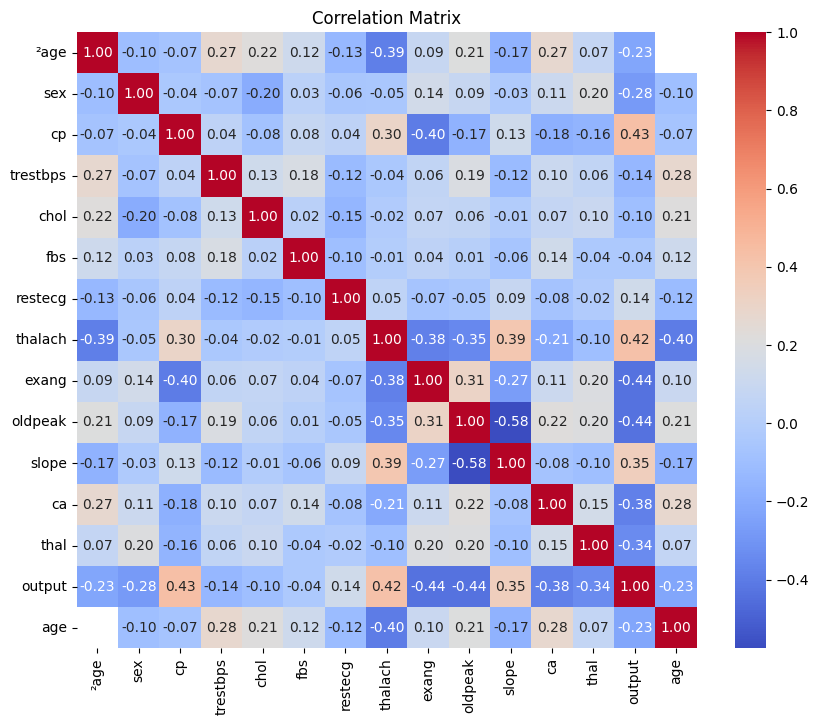

In [14]:
#correlation matrix
corr_matrix = new_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [15]:
#correlation with the output
corr_matrix = corr_matrix.drop('output')
corr_with_output = corr_matrix['output'].sort_values(ascending=False)
print(corr_with_output)


cp          0.434704
thalach     0.422724
slope       0.345709
restecg     0.135011
fbs        -0.038194
chol       -0.096515
trestbps   -0.140117
age        -0.225439
²age       -0.229324
sex        -0.280008
thal       -0.339286
ca         -0.384375
oldpeak    -0.436815
exang      -0.437802
Name: output, dtype: float64


# Machine learning

output: 0 = no disease, 1 = disease

## Training part

split the data

In [16]:
X = new_df.drop('output', axis=1)
y = new_df['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234567)


XGBoost

In [17]:
parameters = {
        "eta": [0.001, 0.01, 0.05, 0.1, 0.3, 0.5],
        "gamma": [0, 0.1, 0.5, 1, 3, 5],
        "max_depth": [5, 10, 15, 25, 50, 100],
        "min_child_weight": [1, 3, 5, 10, 20, 30],
        "subsample": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
        "lambda": [0, 1, 2, 5, 10, 20],
        "alpha": [0, 0.1, 0.5, 1, 5, 10],
        "objective": ["binary:logistic","binary:logitraw"],
    }

def first_training(parameters, X_train, y_train, X_test):
    """
    Perform initial training with RandomizedSearchCV to find the best model.
    
    Args:
        parameters: Dictionary of hyperparameter options for RandomizedSearchCV.
        X_train: Training feature data.
        y_train: Training target labels.
        X_test: Test feature data.

    Returns:
        model: The best-trained XGBClassifier model.
        best_params: Best parameters found during RandomizedSearchCV.
        y_pred_with_xgb: Predictions on the X_test dataset.
    """
    xgb_model = xgb.XGBClassifier()
    n_iter_search = 200  # Number of random parameter configurations to try
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=parameters,
        n_iter=n_iter_search,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train)

    # Get the best parameters and model
    best_params = random_search.best_params_
    print(f"Best Parameters: {best_params}")
    print(f"Best Score: {random_search.best_score_}")

    # Save the trained model
    trained_model = random_search.best_estimator_

    # Make predictions on the test set
    y_pred_with_xgb = trained_model.predict(X_test)
    
    return trained_model, best_params, y_pred_with_xgb

trained_model, best_params, y_pred_with_xgb = first_training(parameters, X_train, y_train, X_test)

def improve_model(model, new_batch):
    """
    Improve an existing XGBClassifier model using new data.
    
    Args:
        model: Trained XGBClassifier model from the first training.
        new_batch: Dataframe with new data to train on.
        parameters: Dictionary of hyperparameters to ensure consistent training.
    
    Returns:
        updated_model: The updated XGBClassifier model.
    """
    parameters = {
        "eta": [0.001, 0.01, 0.05, 0.1, 0.3, 0.5],
        "gamma": [0, 0.1, 0.5, 1, 3, 5],
        "max_depth": [5, 10, 15, 25, 50, 100],
        "min_child_weight": [1, 3, 5, 10, 20, 30],
        "subsample": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
        "lambda": [0, 1, 2, 5, 10, 20],
        "alpha": [0, 0.1, 0.5, 1, 5, 10],
        "objective": ["binary:logistic","binary:logitraw"],
    }
    X_new = new_batch.drop('output', axis=1)
    y_new = new_batch['output']

    # Convert the new data into a DMatrix
    dtrain_new = xgb.DMatrix(data=X_new, label=y_new)

    # Reduce the learning rate for fine-tuning
    parameters['learning_rate'] = parameters.get('learning_rate', 0.1) * 0.5

    # Update the model with new data
    booster = model.get_booster()  # Get the underlying Booster
    booster.update(dtrain_new, iteration=10)  # Incremental update for 10 iterations

    # Save the updated booster back to the XGBClassifier model
    updated_model = model
    updated_model._Booster = booster

    return updated_model
    
    
    

Best Parameters: {'subsample': 0.8, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_depth': 5, 'lambda': 1, 'gamma': 0.5, 'eta': 0.3, 'alpha': 0}
Best Score: -0.024510585525733014


## Results parts

let's compare the efficency using: accuracy,precision, recall and f1-score

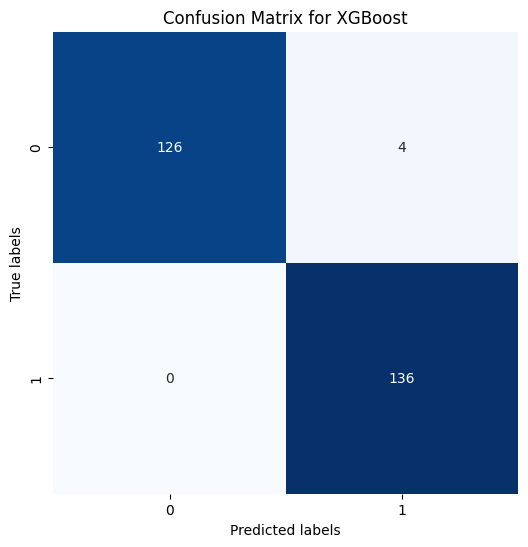

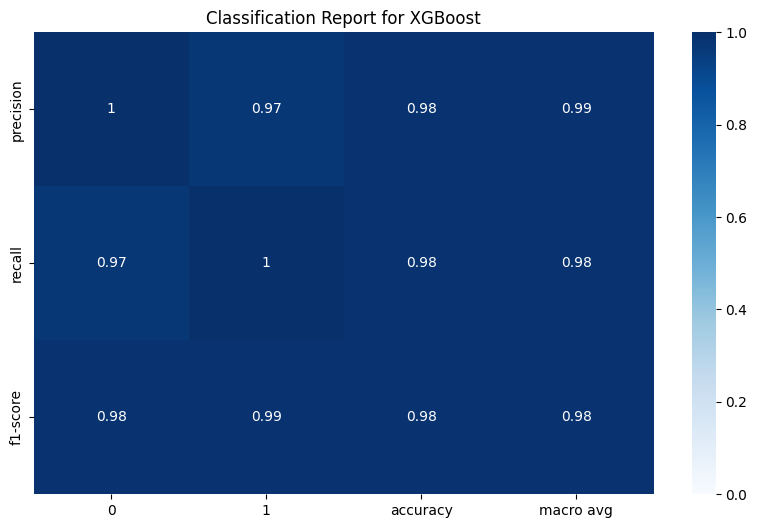

In [18]:

def plot_confusion_matrix(y_test, y_pred, method):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for ' + method)
    plt.show()
    
def plot_classification_report(y_test, y_pred, method):
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.drop(columns=['support'])
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Blues',vmin=0, vmax=1)
    plt.title('Classification Report for ' + method)
    plt.show()

plot_confusion_matrix(y_test, y_pred_with_xgb, 'XGBoost')
plot_classification_report(y_test, y_pred_with_xgb, 'XGBoost')



## testing on realtime data part


In [19]:
def predicted_record(record,model):
    #reshape the record
    record = np.array(record).reshape(1, -1)
    prediction = model.predict(record)
    if prediction == 0:
        prediction = 0
    else:
        prediction = 1
    return prediction


test_record = [57,1,0,220,160,0,1,150,1,1.2,1,1,3]
print(predicted_record(test_record, trained_model))


ValueError: Feature shape mismatch, expected: 14, got 13